[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/eemlcommunity/PracticalSessions2022/blob/main/deepExplain/04_CAM_based_Methods.ipynb)

![picture](https://raw.githubusercontent.com/RosePY/deepexplain/ScoreCAM/ScoreCAM/images/header-cam.jpg)


# CAM-based Methods : CAM, Grad-CAM, Score-CAM


## Highlights


*   Review on Backpropagation and Perturbation-based Methods
*   CAM, Grad-CAM, Score-CAM
*   Drawbacks on saliency-based methods methods



---



This notebook presents  presents  Class Activation Mapping based methods: CAM, Grad-CAM and Score-CAM. These methods try to show which parts of an image a neural network looks for a prediction by using the neurons activated for a particular class. To show how each method works, examples on a Deep Neural Networks trained on Imagenet are given.
Below, in the Introduction section, a small review on types of visual explainability methods is presented. Also, at the end, a small discussion about some drawbacks on other feature attribution methods is provided.

## Introduction 
Visual Explainability Methods  produce a saliency map showing how important each pixel is for their label of classification. These can be generally classified into two types:

**a. Backpropagation-based Methods**


*   Use gradient signals passed from output to input during network training.
*   Saliency maps highlight the pixels most important to the DNN prediction, based on derivatives.
*    Some of these methods are: Activation Maximization , Deconvolution, Grad-CAM, GradCAM++, Layer-Wise Relevance Propagation (LRP), Deep Learning Important FeaTures (DeepLIFT), Integrated Gradients


**b. Perturbation-based Methods**

*   Use the difference in the prediction when the input features are changed. 
*   Perturbations  can be replacing the region with a constant value, adding noise to a region, or blurring a region.
*   The most known methods are Occlusion and Smooth Masks.

## Class Activation Mapping (CAM)

CAM method is designed to work with a DNN with a Global Average Pooling (GAP) layer after the last convolutional layer, and one fully connected layer after the GAP layer. 
Global Average Pooling gives a value for each feature map on convolutional layer, then connected to the fully connected layer, each value obatined with GAP has different weights for each class.

For example, in the Figure 1, to find what the CNN is looking at to predict 'Australian Terrier', we select the weights corresponding to this neuron and multiply it with its corresponding activation map (input image is fed to the DNN till an specific layer) on convolutional layer.  The  published paper is available [here](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)  and official code is on [Github](https://github.com/zhoubolei/CAM).

![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/cam.jpg?raw=true)

*Figure 1: Outline of  Class Activation Mapping. To generate the class
activation maps (CAMs), weights for an specific class are mapped back to its corresponding feature map in the previous convolutional layer. Then, a weighted-sum is obtained with the activation maps and weights giving the contribution of these activation map towards a particular class. Figure reproduced from Zhou et al.[6].*

### Algorithm 


1.   Feed the input image through the CNN and get the predicted class
2.   Select the weights associated to the neuron for the predicted class
3.   Multiply each activation map from the last convolutional layer by its corresponding weight
4.   Sum all weighted actication maps
5.   Scale values to the interval between 0 and 1 for visualization purposes
6.   Upscale the image and overlay it over the original image



### Advantages


*   It is class discriminative, can find what the CNN is looking at for each class.
*   It doesn't need a backpropagation in the whole CNN unlike Deconvolution or Guided Backpropagation


### Disadvantages


*   Since it needs a specific architecture, trained models will need to be modified and retrained, which could lead to less accuracy on the task. Also, CAM could not be used for complex tasks like Image captioning or visual question answering (VQA). 




### Example
This example will show how CAM works using ResNet18, a network wich has the architecture as CAM needs, so there is no need to re-train. This network  will be used also for the other methods' examples.

In [1]:
#@title Utils

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
import torch
import torch.nn.functional as F

from statistics import mode, mean
import numpy as np
import cv2


def reverse_normalize(x1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x = x1.detach().clone()
    x[:, 0, :, :] = x[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = x[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = x[:, 2, :, :] * std[2] + mean[2]
    return x


def superimpose(img, cam1):
    """
    Synthesize an image with CAM to make a result image.
    Args:
        img: (Tensor) shape => (1, 3, H, W)
        cam: (Tensor) shape => (1, 1, H', W')
    Return:
        synthesized image (Tensor): shape =>(1, 3, H, W)
    """

    _, _, H, W = img.shape
    img = reverse_normalize(img).cpu()
    cam = cam1.detach().clone()
    cam = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
    cam = 255 * cam.squeeze()
    heatmap = cv2.applyColorMap(np.uint8(cam), cv2.COLORMAP_VIRIDIS)
    heatmap = torch.from_numpy(heatmap.transpose(2, 0, 1))
    heatmap = heatmap.float() / 255
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = 0.85*heatmap+0.45*img.squeeze()
    result = result.div(result.max())

    return result

def visualize(pil_img,tensor,cam,idx):
    superimposed_img = superimpose(tensor,cam)
    fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
    
    axs[0].imshow(pil_img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(cam.squeeze().numpy())
    axs[1].set_title('Raw CAM')
    axs[1].axis('on')

    axs[2].imshow(superimposed_img.squeeze().numpy().transpose(1, 2, 0))
    axs[2].set_title('Superimposed Image')
    axs[2].axis('off')

    plt.suptitle('Class: ' + idx2label[idx])
    plt.tight_layout()
     
    plt.show()



class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()




In [2]:
#@title ID - Labels - Imagenet
idx2label = {
    0: 'tench, Tinca tinca',
    1: 'goldfish, Carassius auratus',
    2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
    3: 'tiger shark, Galeocerdo cuvieri',
    4: 'hammerhead, hammerhead shark',
    5: 'electric ray, crampfish, numbfish, torpedo',
    6: 'stingray',
    7: 'cock',
    8: 'hen',
    9: 'ostrich, Struthio camelus',
    10: 'brambling, Fringilla montifringilla',
    11: 'goldfinch, Carduelis carduelis',
    12: 'house finch, linnet, Carpodacus mexicanus',
    13: 'junco, snowbird',
    14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
    15: 'robin, American robin, Turdus migratorius',
    16: 'bulbul',
    17: 'jay',
    18: 'magpie',
    19: 'chickadee',
    20: 'water ouzel, dipper',
    21: 'kite',
    22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
    23: 'vulture',
    24: 'great grey owl, great gray owl, Strix nebulosa',
    25: 'European fire salamander, Salamandra salamandra',
    26: 'common newt, Triturus vulgaris',
    27: 'eft',
    28: 'spotted salamander, Ambystoma maculatum',
    29: 'axolotl, mud puppy, Ambystoma mexicanum',
    30: 'bullfrog, Rana catesbeiana',
    31: 'tree frog, tree-frog',
    32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
    33: 'loggerhead, loggerhead turtle, Caretta caretta',
    34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
    35: 'mud turtle',
    36: 'terrapin',
    37: 'box turtle, box tortoise',
    38: 'banded gecko',
    39: 'common iguana, iguana, Iguana iguana',
    40: 'American chameleon, anole, Anolis carolinensis',
    41: 'whiptail, whiptail lizard',
    42: 'agama',
    43: 'frilled lizard, Chlamydosaurus kingi',
    44: 'alligator lizard',
    45: 'Gila monster, Heloderma suspectum',
    46: 'green lizard, Lacerta viridis',
    47: 'African chameleon, Chamaeleo chamaeleon',
    48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
    49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
    50: 'American alligator, Alligator mississipiensis',
    51: 'triceratops',
    52: 'thunder snake, worm snake, Carphophis amoenus',
    53: 'ringneck snake, ring-necked snake, ring snake',
    54: 'hognose snake, puff adder, sand viper',
    55: 'green snake, grass snake',
    56: 'king snake, kingsnake',
    57: 'garter snake, grass snake',
    58: 'water snake',
    59: 'vine snake',
    60: 'night snake, Hypsiglena torquata',
    61: 'boa constrictor, Constrictor constrictor',
    62: 'rock python, rock snake, Python sebae',
    63: 'Indian cobra, Naja naja',
    64: 'green mamba',
    65: 'sea snake',
    66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
    67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
    68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
    69: 'trilobite',
    70: 'harvestman, daddy longlegs, Phalangium opilio',
    71: 'scorpion',
    72: 'black and gold garden spider, Argiope aurantia',
    73: 'barn spider, Araneus cavaticus',
    74: 'garden spider, Aranea diademata',
    75: 'black widow, Latrodectus mactans',
    76: 'tarantula',
    77: 'wolf spider, hunting spider',
    78: 'tick',
    79: 'centipede',
    80: 'black grouse',
    81: 'ptarmigan',
    82: 'ruffed grouse, partridge, Bonasa umbellus',
    83: 'prairie chicken, prairie grouse, prairie fowl',
    84: 'peacock',
    85: 'quail',
    86: 'partridge',
    87: 'African grey, African gray, Psittacus erithacus',
    88: 'macaw',
    89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
    90: 'lorikeet',
    91: 'coucal',
    92: 'bee eater',
    93: 'hornbill',
    94: 'hummingbird',
    95: 'jacamar',
    96: 'toucan',
    97: 'drake',
    98: 'red-breasted merganser, Mergus serrator',
    99: 'goose',
    100: 'black swan, Cygnus atratus',
    101: 'tusker',
    102: 'echidna, spiny anteater, anteater',
    103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
    104: 'wallaby, brush kangaroo',
    105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
    106: 'wombat',
    107: 'jellyfish',
    108: 'sea anemone, anemone',
    109: 'brain coral',
    110: 'flatworm, platyhelminth',
    111: 'nematode, nematode worm, roundworm',
    112: 'conch',
    113: 'snail',
    114: 'slug',
    115: 'sea slug, nudibranch',
    116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
    117: 'chambered nautilus, pearly nautilus, nautilus',
    118: 'Dungeness crab, Cancer magister',
    119: 'rock crab, Cancer irroratus',
    120: 'fiddler crab',
    121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
    122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
    123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
    124: 'crayfish, crawfish, crawdad, crawdaddy',
    125: 'hermit crab',
    126: 'isopod',
    127: 'white stork, Ciconia ciconia',
    128: 'black stork, Ciconia nigra',
    129: 'spoonbill',
    130: 'flamingo',
    131: 'little blue heron, Egretta caerulea',
    132: 'American egret, great white heron, Egretta albus',
    133: 'bittern',
    134: 'crane',
    135: 'limpkin, Aramus pictus',
    136: 'European gallinule, Porphyrio porphyrio',
    137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
    138: 'bustard',
    139: 'ruddy turnstone, Arenaria interpres',
    140: 'red-backed sandpiper, dunlin, Erolia alpina',
    141: 'redshank, Tringa totanus',
    142: 'dowitcher',
    143: 'oystercatcher, oyster catcher',
    144: 'pelican',
    145: 'king penguin, Aptenodytes patagonica',
    146: 'albatross, mollymawk',
    147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
    148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
    149: 'dugong, Dugong dugon',
    150: 'sea lion',
    151: 'Chihuahua',
    152: 'Japanese spaniel',
    153: 'Maltese dog, Maltese terrier, Maltese',
    154: 'Pekinese, Pekingese, Peke',
    155: 'Shih-Tzu',
    156: 'Blenheim spaniel',
    157: 'papillon',
    158: 'toy terrier',
    159: 'Rhodesian ridgeback',
    160: 'Afghan hound, Afghan',
    161: 'basset, basset hound',
    162: 'beagle',
    163: 'bloodhound, sleuthhound',
    164: 'bluetick',
    165: 'black-and-tan coonhound',
    166: 'Walker hound, Walker foxhound',
    167: 'English foxhound',
    168: 'redbone',
    169: 'borzoi, Russian wolfhound',
    170: 'Irish wolfhound',
    171: 'Italian greyhound',
    172: 'whippet',
    173: 'Ibizan hound, Ibizan Podenco',
    174: 'Norwegian elkhound, elkhound',
    175: 'otterhound, otter hound',
    176: 'Saluki, gazelle hound',
    177: 'Scottish deerhound, deerhound',
    178: 'Weimaraner',
    179: 'Staffordshire bullterrier, Staffordshire bull terrier',
    180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
    181: 'Bedlington terrier',
    182: 'Border terrier',
    183: 'Kerry blue terrier',
    184: 'Irish terrier',
    185: 'Norfolk terrier',
    186: 'Norwich terrier',
    187: 'Yorkshire terrier',
    188: 'wire-haired fox terrier',
    189: 'Lakeland terrier',
    190: 'Sealyham terrier, Sealyham',
    191: 'Airedale, Airedale terrier',
    192: 'cairn, cairn terrier',
    193: 'Australian terrier',
    194: 'Dandie Dinmont, Dandie Dinmont terrier',
    195: 'Boston bull, Boston terrier',
    196: 'miniature schnauzer',
    197: 'giant schnauzer',
    198: 'standard schnauzer',
    199: 'Scotch terrier, Scottish terrier, Scottie',
    200: 'Tibetan terrier, chrysanthemum dog',
    201: 'silky terrier, Sydney silky',
    202: 'soft-coated wheaten terrier',
    203: 'West Highland white terrier',
    204: 'Lhasa, Lhasa apso',
    205: 'flat-coated retriever',
    206: 'curly-coated retriever',
    207: 'golden retriever',
    208: 'Labrador retriever',
    209: 'Chesapeake Bay retriever',
    210: 'German short-haired pointer',
    211: 'vizsla, Hungarian pointer',
    212: 'English setter',
    213: 'Irish setter, red setter',
    214: 'Gordon setter',
    215: 'Brittany spaniel',
    216: 'clumber, clumber spaniel',
    217: 'English springer, English springer spaniel',
    218: 'Welsh springer spaniel',
    219: 'cocker spaniel, English cocker spaniel, cocker',
    220: 'Sussex spaniel',
    221: 'Irish water spaniel',
    222: 'kuvasz',
    223: 'schipperke',
    224: 'groenendael',
    225: 'malinois',
    226: 'briard',
    227: 'kelpie',
    228: 'komondor',
    229: 'Old English sheepdog, bobtail',
    230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
    231: 'collie',
    232: 'Border collie',
    233: 'Bouvier des Flandres, Bouviers des Flandres',
    234: 'Rottweiler',
    235: 'German shepherd, German shepherd dog, German police dog, alsatian',
    236: 'Doberman, Doberman pinscher',
    237: 'miniature pinscher',
    238: 'Greater Swiss Mountain dog',
    239: 'Bernese mountain dog',
    240: 'Appenzeller',
    241: 'EntleBucher',
    242: 'boxer',
    243: 'bull mastiff',
    244: 'Tibetan mastiff',
    245: 'French bulldog',
    246: 'Great Dane',
    247: 'Saint Bernard, St Bernard',
    248: 'Eskimo dog, husky',
    249: 'malamute, malemute, Alaskan malamute',
    250: 'Siberian husky',
    251: 'dalmatian, coach dog, carriage dog',
    252: 'affenpinscher, monkey pinscher, monkey dog',
    253: 'basenji',
    254: 'pug, pug-dog',
    255: 'Leonberg',
    256: 'Newfoundland, Newfoundland dog',
    257: 'Great Pyrenees',
    258: 'Samoyed, Samoyede',
    259: 'Pomeranian',
    260: 'chow, chow chow',
    261: 'keeshond',
    262: 'Brabancon griffon',
    263: 'Pembroke, Pembroke Welsh corgi',
    264: 'Cardigan, Cardigan Welsh corgi',
    265: 'toy poodle',
    266: 'miniature poodle',
    267: 'standard poodle',
    268: 'Mexican hairless',
    269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
    270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
    271: 'red wolf, maned wolf, Canis rufus, Canis niger',
    272: 'coyote, prairie wolf, brush wolf, Canis latrans',
    273: 'dingo, warrigal, warragal, Canis dingo',
    274: 'dhole, Cuon alpinus',
    275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
    276: 'hyena, hyaena',
    277: 'red fox, Vulpes vulpes',
    278: 'kit fox, Vulpes macrotis',
    279: 'Arctic fox, white fox, Alopex lagopus',
    280: 'grey fox, gray fox, Urocyon cinereoargenteus',
    281: 'tabby, tabby cat',
    282: 'tiger cat',
    283: 'Persian cat',
    284: 'Siamese cat, Siamese',
    285: 'Egyptian cat',
    286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
    287: 'lynx, catamount',
    288: 'leopard, Panthera pardus',
    289: 'snow leopard, ounce, Panthera uncia',
    290: 'jaguar, panther, Panthera onca, Felis onca',
    291: 'lion, king of beasts, Panthera leo',
    292: 'tiger, Panthera tigris',
    293: 'cheetah, chetah, Acinonyx jubatus',
    294: 'brown bear, bruin, Ursus arctos',
    295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
    296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
    297: 'sloth bear, Melursus ursinus, Ursus ursinus',
    298: 'mongoose',
    299: 'meerkat, mierkat',
    300: 'tiger beetle',
    301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
    302: 'ground beetle, carabid beetle',
    303: 'long-horned beetle, longicorn, longicorn beetle',
    304: 'leaf beetle, chrysomelid',
    305: 'dung beetle',
    306: 'rhinoceros beetle',
    307: 'weevil',
    308: 'fly',
    309: 'bee',
    310: 'ant, emmet, pismire',
    311: 'grasshopper, hopper',
    312: 'cricket',
    313: 'walking stick, walkingstick, stick insect',
    314: 'cockroach, roach',
    315: 'mantis, mantid',
    316: 'cicada, cicala',
    317: 'leafhopper',
    318: 'lacewing, lacewing fly',
    319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
    320: 'damselfly',
    321: 'admiral',
    322: 'ringlet, ringlet butterfly',
    323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
    324: 'cabbage butterfly',
    325: 'sulphur butterfly, sulfur butterfly',
    326: 'lycaenid, lycaenid butterfly',
    327: 'starfish, sea star',
    328: 'sea urchin',
    329: 'sea cucumber, holothurian',
    330: 'wood rabbit, cottontail, cottontail rabbit',
    331: 'hare',
    332: 'Angora, Angora rabbit',
    333: 'hamster',
    334: 'porcupine, hedgehog',
    335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
    336: 'marmot',
    337: 'beaver',
    338: 'guinea pig, Cavia cobaya',
    339: 'sorrel',
    340: 'zebra',
    341: 'hog, pig, grunter, squealer, Sus scrofa',
    342: 'wild boar, boar, Sus scrofa',
    343: 'warthog',
    344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
    345: 'ox',
    346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
    347: 'bison',
    348: 'ram, tup',
    349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
    350: 'ibex, Capra ibex',
    351: 'hartebeest',
    352: 'impala, Aepyceros melampus',
    353: 'gazelle',
    354: 'Arabian camel, dromedary, Camelus dromedarius',
    355: 'llama',
    356: 'weasel',
    357: 'mink',
    358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
    359: 'black-footed ferret, ferret, Mustela nigripes',
    360: 'otter',
    361: 'skunk, polecat, wood pussy',
    362: 'badger',
    363: 'armadillo',
    364: 'three-toed sloth, ai, Bradypus tridactylus',
    365: 'orangutan, orang, orangutang, Pongo pygmaeus',
    366: 'gorilla, Gorilla gorilla',
    367: 'chimpanzee, chimp, Pan troglodytes',
    368: 'gibbon, Hylobates lar',
    369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
    370: 'guenon, guenon monkey',
    371: 'patas, hussar monkey, Erythrocebus patas',
    372: 'baboon',
    373: 'macaque',
    374: 'langur',
    375: 'colobus, colobus monkey',
    376: 'proboscis monkey, Nasalis larvatus',
    377: 'marmoset',
    378: 'capuchin, ringtail, Cebus capucinus',
    379: 'howler monkey, howler',
    380: 'titi, titi monkey',
    381: 'spider monkey, Ateles geoffroyi',
    382: 'squirrel monkey, Saimiri sciureus',
    383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
    384: 'indri, indris, Indri indri, Indri brevicaudatus',
    385: 'Indian elephant, Elephas maximus',
    386: 'African elephant, Loxodonta africana',
    387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
    388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
    389: 'barracouta, snoek',
    390: 'eel',
    391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
    392: 'rock beauty, Holocanthus tricolor',
    393: 'anemone fish',
    394: 'sturgeon',
    395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
    396: 'lionfish',
    397: 'puffer, pufferfish, blowfish, globefish',
    398: 'abacus',
    399: 'abaya',
    400: "academic gown, academic robe, judge's robe",
    401: 'accordion, piano accordion, squeeze box',
    402: 'acoustic guitar',
    403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
    404: 'airliner',
    405: 'airship, dirigible',
    406: 'altar',
    407: 'ambulance',
    408: 'amphibian, amphibious vehicle',
    409: 'analog clock',
    410: 'apiary, bee house',
    411: 'apron',
    412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
    413: 'assault rifle, assault gun',
    414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
    415: 'bakery, bakeshop, bakehouse',
    416: 'balance beam, beam',
    417: 'balloon',
    418: 'ballpoint, ballpoint pen, ballpen, Biro',
    419: 'Band Aid',
    420: 'banjo',
    421: 'bannister, banister, balustrade, balusters, handrail',
    422: 'barbell',
    423: 'barber chair',
    424: 'barbershop',
    425: 'barn',
    426: 'barometer',
    427: 'barrel, cask',
    428: 'barrow, garden cart, lawn cart, wheelbarrow',
    429: 'baseball',
    430: 'basketball',
    431: 'bassinet',
    432: 'bassoon',
    433: 'bathing cap, swimming cap',
    434: 'bath towel',
    435: 'bathtub, bathing tub, bath, tub',
    436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
    437: 'beacon, lighthouse, beacon light, pharos',
    438: 'beaker',
    439: 'bearskin, busby, shako',
    440: 'beer bottle',
    441: 'beer glass',
    442: 'bell cote, bell cot',
    443: 'bib',
    444: 'bicycle-built-for-two, tandem bicycle, tandem',
    445: 'bikini, two-piece',
    446: 'binder, ring-binder',
    447: 'binoculars, field glasses, opera glasses',
    448: 'birdhouse',
    449: 'boathouse',
    450: 'bobsled, bobsleigh, bob',
    451: 'bolo tie, bolo, bola tie, bola',
    452: 'bonnet, poke bonnet',
    453: 'bookcase',
    454: 'bookshop, bookstore, bookstall',
    455: 'bottlecap',
    456: 'bow',
    457: 'bow tie, bow-tie, bowtie',
    458: 'brass, memorial tablet, plaque',
    459: 'brassiere, bra, bandeau',
    460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
    461: 'breastplate, aegis, egis',
    462: 'broom',
    463: 'bucket, pail',
    464: 'buckle',
    465: 'bulletproof vest',
    466: 'bullet train, bullet',
    467: 'butcher shop, meat market',
    468: 'cab, hack, taxi, taxicab',
    469: 'caldron, cauldron',
    470: 'candle, taper, wax light',
    471: 'cannon',
    472: 'canoe',
    473: 'can opener, tin opener',
    474: 'cardigan',
    475: 'car mirror',
    476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
    477: "carpenter's kit, tool kit",
    478: 'carton',
    479: 'car wheel',
    480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
    481: 'cassette',
    482: 'cassette player',
    483: 'castle',
    484: 'catamaran',
    485: 'CD player',
    486: 'cello, violoncello',
    487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
    488: 'chain',
    489: 'chainlink fence',
    490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
    491: 'chain saw, chainsaw',
    492: 'chest',
    493: 'chiffonier, commode',
    494: 'chime, bell, gong',
    495: 'china cabinet, china closet',
    496: 'Christmas stocking',
    497: 'church, church building',
    498: 'cinema, movie theater, movie theatre, movie house, picture palace',
    499: 'cleaver, meat cleaver, chopper',
    500: 'cliff dwelling',
    501: 'cloak',
    502: 'clog, geta, patten, sabot',
    503: 'cocktail shaker',
    504: 'coffee mug',
    505: 'coffeepot',
    506: 'coil, spiral, volute, whorl, helix',
    507: 'combination lock',
    508: 'computer keyboard, keypad',
    509: 'confectionery, confectionary, candy store',
    510: 'container ship, containership, container vessel',
    511: 'convertible',
    512: 'corkscrew, bottle screw',
    513: 'cornet, horn, trumpet, trump',
    514: 'cowboy boot',
    515: 'cowboy hat, ten-gallon hat',
    516: 'cradle',
    517: 'crane',
    518: 'crash helmet',
    519: 'crate',
    520: 'crib, cot',
    521: 'Crock Pot',
    522: 'croquet ball',
    523: 'crutch',
    524: 'cuirass',
    525: 'dam, dike, dyke',
    526: 'desk',
    527: 'desktop computer',
    528: 'dial telephone, dial phone',
    529: 'diaper, nappy, napkin',
    530: 'digital clock',
    531: 'digital watch',
    532: 'dining table, board',
    533: 'dishrag, dishcloth',
    534: 'dishwasher, dish washer, dishwashing machine',
    535: 'disk brake, disc brake',
    536: 'dock, dockage, docking facility',
    537: 'dogsled, dog sled, dog sleigh',
    538: 'dome',
    539: 'doormat, welcome mat',
    540: 'drilling platform, offshore rig',
    541: 'drum, membranophone, tympan',
    542: 'drumstick',
    543: 'dumbbell',
    544: 'Dutch oven',
    545: 'electric fan, blower',
    546: 'electric guitar',
    547: 'electric locomotive',
    548: 'entertainment center',
    549: 'envelope',
    550: 'espresso maker',
    551: 'face powder',
    552: 'feather boa, boa',
    553: 'file, file cabinet, filing cabinet',
    554: 'fireboat',
    555: 'fire engine, fire truck',
    556: 'fire screen, fireguard',
    557: 'flagpole, flagstaff',
    558: 'flute, transverse flute',
    559: 'folding chair',
    560: 'football helmet',
    561: 'forklift',
    562: 'fountain',
    563: 'fountain pen',
    564: 'four-poster',
    565: 'freight car',
    566: 'French horn, horn',
    567: 'frying pan, frypan, skillet',
    568: 'fur coat',
    569: 'garbage truck, dustcart',
    570: 'gasmask, respirator, gas helmet',
    571: 'gas pump, gasoline pump, petrol pump, island dispenser',
    572: 'goblet',
    573: 'go-kart',
    574: 'golf ball',
    575: 'golfcart, golf cart',
    576: 'gondola',
    577: 'gong, tam-tam',
    578: 'gown',
    579: 'grand piano, grand',
    580: 'greenhouse, nursery, glasshouse',
    581: 'grille, radiator grille',
    582: 'grocery store, grocery, food market, market',
    583: 'guillotine',
    584: 'hair slide',
    585: 'hair spray',
    586: 'half track',
    587: 'hammer',
    588: 'hamper',
    589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
    590: 'hand-held computer, hand-held microcomputer',
    591: 'handkerchief, hankie, hanky, hankey',
    592: 'hard disc, hard disk, fixed disk',
    593: 'harmonica, mouth organ, harp, mouth harp',
    594: 'harp',
    595: 'harvester, reaper',
    596: 'hatchet',
    597: 'holster',
    598: 'home theater, home theatre',
    599: 'honeycomb',
    600: 'hook, claw',
    601: 'hoopskirt, crinoline',
    602: 'horizontal bar, high bar',
    603: 'horse cart, horse-cart',
    604: 'hourglass',
    605: 'iPod',
    606: 'iron, smoothing iron',
    607: "jack-o'-lantern",
    608: 'jean, blue jean, denim',
    609: 'jeep, landrover',
    610: 'jersey, T-shirt, tee shirt',
    611: 'jigsaw puzzle',
    612: 'jinrikisha, ricksha, rickshaw',
    613: 'joystick',
    614: 'kimono',
    615: 'knee pad',
    616: 'knot',
    617: 'lab coat, laboratory coat',
    618: 'ladle',
    619: 'lampshade, lamp shade',
    620: 'laptop, laptop computer',
    621: 'lawn mower, mower',
    622: 'lens cap, lens cover',
    623: 'letter opener, paper knife, paperknife',
    624: 'library',
    625: 'lifeboat',
    626: 'lighter, light, igniter, ignitor',
    627: 'limousine, limo',
    628: 'liner, ocean liner',
    629: 'lipstick, lip rouge',
    630: 'Loafer',
    631: 'lotion',
    632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
    633: "loupe, jeweler's loupe",
    634: 'lumbermill, sawmill',
    635: 'magnetic compass',
    636: 'mailbag, postbag',
    637: 'mailbox, letter box',
    638: 'maillot',
    639: 'maillot, tank suit',
    640: 'manhole cover',
    641: 'maraca',
    642: 'marimba, xylophone',
    643: 'mask',
    644: 'matchstick',
    645: 'maypole',
    646: 'maze, labyrinth',
    647: 'measuring cup',
    648: 'medicine chest, medicine cabinet',
    649: 'megalith, megalithic structure',
    650: 'microphone, mike',
    651: 'microwave, microwave oven',
    652: 'military uniform',
    653: 'milk can',
    654: 'minibus',
    655: 'miniskirt, mini',
    656: 'minivan',
    657: 'missile',
    658: 'mitten',
    659: 'mixing bowl',
    660: 'mobile home, manufactured home',
    661: 'Model T',
    662: 'modem',
    663: 'monastery',
    664: 'monitor',
    665: 'moped',
    666: 'mortar',
    667: 'mortarboard',
    668: 'mosque',
    669: 'mosquito net',
    670: 'motor scooter, scooter',
    671: 'mountain bike, all-terrain bike, off-roader',
    672: 'mountain tent',
    673: 'mouse, computer mouse',
    674: 'mousetrap',
    675: 'moving van',
    676: 'muzzle',
    677: 'nail',
    678: 'neck brace',
    679: 'necklace',
    680: 'nipple',
    681: 'notebook, notebook computer',
    682: 'obelisk',
    683: 'oboe, hautboy, hautbois',
    684: 'ocarina, sweet potato',
    685: 'odometer, hodometer, mileometer, milometer',
    686: 'oil filter',
    687: 'organ, pipe organ',
    688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
    689: 'overskirt',
    690: 'oxcart',
    691: 'oxygen mask',
    692: 'packet',
    693: 'paddle, boat paddle',
    694: 'paddlewheel, paddle wheel',
    695: 'padlock',
    696: 'paintbrush',
    697: "pajama, pyjama, pj's, jammies",
    698: 'palace',
    699: 'panpipe, pandean pipe, syrinx',
    700: 'paper towel',
    701: 'parachute, chute',
    702: 'parallel bars, bars',
    703: 'park bench',
    704: 'parking meter',
    705: 'passenger car, coach, carriage',
    706: 'patio, terrace',
    707: 'pay-phone, pay-station',
    708: 'pedestal, plinth, footstall',
    709: 'pencil box, pencil case',
    710: 'pencil sharpener',
    711: 'perfume, essence',
    712: 'Petri dish',
    713: 'photocopier',
    714: 'pick, plectrum, plectron',
    715: 'pickelhaube',
    716: 'picket fence, paling',
    717: 'pickup, pickup truck',
    718: 'pier',
    719: 'piggy bank, penny bank',
    720: 'pill bottle',
    721: 'pillow',
    722: 'ping-pong ball',
    723: 'pinwheel',
    724: 'pirate, pirate ship',
    725: 'pitcher, ewer',
    726: "plane, carpenter's plane, woodworking plane",
    727: 'planetarium',
    728: 'plastic bag',
    729: 'plate rack',
    730: 'plow, plough',
    731: "plunger, plumber's helper",
    732: 'Polaroid camera, Polaroid Land camera',
    733: 'pole',
    734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
    735: 'poncho',
    736: 'pool table, billiard table, snooker table',
    737: 'pop bottle, soda bottle',
    738: 'pot, flowerpot',
    739: "potter's wheel",
    740: 'power drill',
    741: 'prayer rug, prayer mat',
    742: 'printer',
    743: 'prison, prison house',
    744: 'projectile, missile',
    745: 'projector',
    746: 'puck, hockey puck',
    747: 'punching bag, punch bag, punching ball, punchball',
    748: 'purse',
    749: 'quill, quill pen',
    750: 'quilt, comforter, comfort, puff',
    751: 'racer, race car, racing car',
    752: 'racket, racquet',
    753: 'radiator',
    754: 'radio, wireless',
    755: 'radio telescope, radio reflector',
    756: 'rain barrel',
    757: 'recreational vehicle, RV, R.V.',
    758: 'reel',
    759: 'reflex camera',
    760: 'refrigerator, icebox',
    761: 'remote control, remote',
    762: 'restaurant, eating house, eating place, eatery',
    763: 'revolver, six-gun, six-shooter',
    764: 'rifle',
    765: 'rocking chair, rocker',
    766: 'rotisserie',
    767: 'rubber eraser, rubber, pencil eraser',
    768: 'rugby ball',
    769: 'rule, ruler',
    770: 'running shoe',
    771: 'safe',
    772: 'safety pin',
    773: 'saltshaker, salt shaker',
    774: 'sandal',
    775: 'sarong',
    776: 'sax, saxophone',
    777: 'scabbard',
    778: 'scale, weighing machine',
    779: 'school bus',
    780: 'schooner',
    781: 'scoreboard',
    782: 'screen, CRT screen',
    783: 'screw',
    784: 'screwdriver',
    785: 'seat belt, seatbelt',
    786: 'sewing machine',
    787: 'shield, buckler',
    788: 'shoe shop, shoe-shop, shoe store',
    789: 'shoji',
    790: 'shopping basket',
    791: 'shopping cart',
    792: 'shovel',
    793: 'shower cap',
    794: 'shower curtain',
    795: 'ski',
    796: 'ski mask',
    797: 'sleeping bag',
    798: 'slide rule, slipstick',
    799: 'sliding door',
    800: 'slot, one-armed bandit',
    801: 'snorkel',
    802: 'snowmobile',
    803: 'snowplow, snowplough',
    804: 'soap dispenser',
    805: 'soccer ball',
    806: 'sock',
    807: 'solar dish, solar collector, solar furnace',
    808: 'sombrero',
    809: 'soup bowl',
    810: 'space bar',
    811: 'space heater',
    812: 'space shuttle',
    813: 'spatula',
    814: 'speedboat',
    815: "spider web, spider's web",
    816: 'spindle',
    817: 'sports car, sport car',
    818: 'spotlight, spot',
    819: 'stage',
    820: 'steam locomotive',
    821: 'steel arch bridge',
    822: 'steel drum',
    823: 'stethoscope',
    824: 'stole',
    825: 'stone wall',
    826: 'stopwatch, stop watch',
    827: 'stove',
    828: 'strainer',
    829: 'streetcar, tram, tramcar, trolley, trolley car',
    830: 'stretcher',
    831: 'studio couch, day bed',
    832: 'stupa, tope',
    833: 'submarine, pigboat, sub, U-boat',
    834: 'suit, suit of clothes',
    835: 'sundial',
    836: 'sunglass',
    837: 'sunglasses, dark glasses, shades',
    838: 'sunscreen, sunblock, sun blocker',
    839: 'suspension bridge',
    840: 'swab, swob, mop',
    841: 'sweatshirt',
    842: 'swimming trunks, bathing trunks',
    843: 'swing',
    844: 'switch, electric switch, electrical switch',
    845: 'syringe',
    846: 'table lamp',
    847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
    848: 'tape player',
    849: 'teapot',
    850: 'teddy, teddy bear',
    851: 'television, television system',
    852: 'tennis ball',
    853: 'thatch, thatched roof',
    854: 'theater curtain, theatre curtain',
    855: 'thimble',
    856: 'thresher, thrasher, threshing machine',
    857: 'throne',
    858: 'tile roof',
    859: 'toaster',
    860: 'tobacco shop, tobacconist shop, tobacconist',
    861: 'toilet seat',
    862: 'torch',
    863: 'totem pole',
    864: 'tow truck, tow car, wrecker',
    865: 'toyshop',
    866: 'tractor',
    867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
    868: 'tray',
    869: 'trench coat',
    870: 'tricycle, trike, velocipede',
    871: 'trimaran',
    872: 'tripod',
    873: 'triumphal arch',
    874: 'trolleybus, trolley coach, trackless trolley',
    875: 'trombone',
    876: 'tub, vat',
    877: 'turnstile',
    878: 'typewriter keyboard',
    879: 'umbrella',
    880: 'unicycle, monocycle',
    881: 'upright, upright piano',
    882: 'vacuum, vacuum cleaner',
    883: 'vase',
    884: 'vault',
    885: 'velvet',
    886: 'vending machine',
    887: 'vestment',
    888: 'viaduct',
    889: 'violin, fiddle',
    890: 'volleyball',
    891: 'waffle iron',
    892: 'wall clock',
    893: 'wallet, billfold, notecase, pocketbook',
    894: 'wardrobe, closet, press',
    895: 'warplane, military plane',
    896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
    897: 'washer, automatic washer, washing machine',
    898: 'water bottle',
    899: 'water jug',
    900: 'water tower',
    901: 'whiskey jug',
    902: 'whistle',
    903: 'wig',
    904: 'window screen',
    905: 'window shade',
    906: 'Windsor tie',
    907: 'wine bottle',
    908: 'wing',
    909: 'wok',
    910: 'wooden spoon',
    911: 'wool, woolen, woollen',
    912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
    913: 'wreck',
    914: 'yawl',
    915: 'yurt',
    916: 'web site, website, internet site, site',
    917: 'comic book',
    918: 'crossword puzzle, crossword',
    919: 'street sign',
    920: 'traffic light, traffic signal, stoplight',
    921: 'book jacket, dust cover, dust jacket, dust wrapper',
    922: 'menu',
    923: 'plate',
    924: 'guacamole',
    925: 'consomme',
    926: 'hot pot, hotpot',
    927: 'trifle',
    928: 'ice cream, icecream',
    929: 'ice lolly, lolly, lollipop, popsicle',
    930: 'French loaf',
    931: 'bagel, beigel',
    932: 'pretzel',
    933: 'cheeseburger',
    934: 'hotdog, hot dog, red hot',
    935: 'mashed potato',
    936: 'head cabbage',
    937: 'broccoli',
    938: 'cauliflower',
    939: 'zucchini, courgette',
    940: 'spaghetti squash',
    941: 'acorn squash',
    942: 'butternut squash',
    943: 'cucumber, cuke',
    944: 'artichoke, globe artichoke',
    945: 'bell pepper',
    946: 'cardoon',
    947: 'mushroom',
    948: 'Granny Smith',
    949: 'strawberry',
    950: 'orange',
    951: 'lemon',
    952: 'fig',
    953: 'pineapple, ananas',
    954: 'banana',
    955: 'jackfruit, jak, jack',
    956: 'custard apple',
    957: 'pomegranate',
    958: 'hay',
    959: 'carbonara',
    960: 'chocolate sauce, chocolate syrup',
    961: 'dough',
    962: 'meat loaf, meatloaf',
    963: 'pizza, pizza pie',
    964: 'potpie',
    965: 'burrito',
    966: 'red wine',
    967: 'espresso',
    968: 'cup',
    969: 'eggnog',
    970: 'alp',
    971: 'bubble',
    972: 'cliff, drop, drop-off',
    973: 'coral reef',
    974: 'geyser',
    975: 'lakeside, lakeshore',
    976: 'promontory, headland, head, foreland',
    977: 'sandbar, sand bar',
    978: 'seashore, coast, seacoast, sea-coast',
    979: 'valley, vale',
    980: 'volcano',
    981: 'ballplayer, baseball player',
    982: 'groom, bridegroom',
    983: 'scuba diver',
    984: 'rapeseed',
    985: 'daisy',
    986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
    987: 'corn',
    988: 'acorn',
    989: 'hip, rose hip, rosehip',
    990: 'buckeye, horse chestnut, conker',
    991: 'coral fungus',
    992: 'agaric',
    993: 'gyromitra',
    994: 'stinkhorn, carrion fungus',
    995: 'earthstar',
    996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
    997: 'bolete',
    998: 'ear, spike, capitulum',
    999: 'toilet tissue, toilet paper, bathroom tissue'
}

label2idx = {label: idx for idx, label in idx2label.items()}

In [3]:

%matplotlib inline

import urllib.request
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image



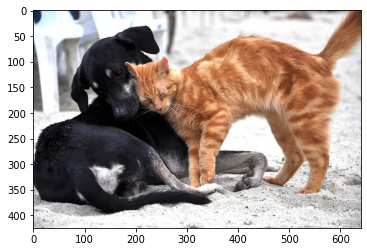

In [4]:
#Choosing an image
## HERE YOU CAN TRY WITH OTHER IMAGES ^.^

url = 'https://raw.githubusercontent.com/RosePY/deepexplain/ScoreCAM/ScoreCAM/images/dog-g7cde20db5_640.jpg'
file_name = "image_cat_dog.jpg"
urllib.request.urlretrieve(url, file_name)

image = Image.open(file_name)

imshow(image)

In [5]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [6]:
#Loading ResNet
model = models.resnet18(pretrained=True)
model.eval()
# See netwwork acrhitecture, so , we can choose a layer
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# the target layer you want to visualize
target_layer = model.layer4[1].conv2

Since CAM is class-discriminative, we can see what the network is looking at each class-label, let's choose:  'Egyptian cat' (index: 285) and  'Labrador retriever' (index: 208).


In [8]:
#first 5 predictions for image.
score = model(tensor)
prob = F.softmax(score, dim=1)
_, indices = torch.sort(prob, descending=True)
top5=[(int(idx),idx2label[int(idx)], prob[0][(idx)].item()) for idx in indices[0][:5]]
top5

[(285, 'Egyptian cat', 0.025514770299196243),
 (281, 'tabby, tabby cat', 0.025300705805420876),
 (282, 'tiger cat', 0.022622225806117058),
 (208, 'Labrador retriever', 0.01840203069150448),
 (205, 'flat-coated retriever', 0.017194140702486038)]

In [9]:
# CAM Code
class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer,idx):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
            idx : Label Index 
        """
        self.idx = None
        self.model = model
        self.target_layer = target_layer
        self.idx = idx

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if self.idx is None:
            prob, idx = torch.max(prob, dim=1)
            self.idx = idx.item()
            prob = prob.item()
            print("predicted class ids {} - {} \t probability {}".format(idx,idx2label[int(idx)], prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, self.idx,weight_fc)

        return cam, self.idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, idx,weight_fc ):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted or chosen class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data

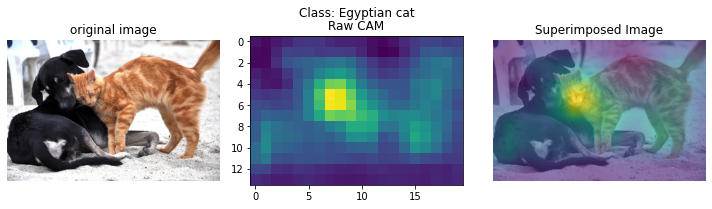

In [10]:
# CAM for egyptian cat
wrapped_model_CAM = CAM(model, target_layer,285)
cam_cat, idx_pred = wrapped_model_CAM(tensor)
visualize(image,tensor,cam_cat,idx_pred)

In [11]:
# NOW IT IS YOUR TURN! Complete the code to get the CAM for Labrador 
#                      Retriever(Index label = 208)

# Uncomment the following lines 

# wrapped_model_CAM = # to be completed
# cam_dog, idx_pred = # to be completed

# visualize(image,tensor,cam_dog,idx_pred)


In [12]:
#@title Solution: CAM for Labrador Retriever

# wrapped_model_CAM = CAM(model, target_layer,208)
# cam_dog, idx_pred = wrapped_model_CAM(tensor)
# visualize(image,tensor,cam_dog,idx_pred)

As it can be observed CAM highlights parts related to the desired classes. 

## Grad-CAM: Gradient-weighted Class Activation Map

Gradient-weighted Class Activation Mapping (Grad-CAM) is a generalization of the Class Activation Mapping, allowing to use it in diferent network architectures and complex tasks without the need of re-training. It uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a  localization map of the important regions in the image. The  published paper is available [here](https://arxiv.org/abs/1610.02391)  and official code is on [Github](https://github.com/ramprs/grad-cam).
  

![picture](https://raw.githubusercontent.com/RosePY/deepexplain/ScoreCAM/ScoreCAM/images/grad-cam-mod.png)

*Figure 2: Outline of Grad-CAM: Gradient-weighted Class Activation Map. Given an image and a class of interest (e.g., ‘tiger cat’ or any other type of differentiable output) as input, the image is forward propagated
through the CNN part of the model and then through task-specific computations to obtain a raw score for the category. The gradient for the desired class (tiger cat) is then backpropagated to convolutional feature maps, which are combined to compute the coarse
Grad-CAM localization (blue heatmap) which represents where the model has to look to make the particular decision.  Figure reproduced from Selvaraju et al.[7].* 

### Algorithm [8]


1.   Feed the input image through the CNN.
2.   Obtain the raw score for the class of interest, meaning the activation of the neuron before the softmax layer.
3. Set all other class activations to zero.
4.   Back-propagate the gradient of the class of interest to the last convolutional layer before the fully connected layers.
5. Apply a Global Pooling operation on gradients matrix and multiply with each activation map
6.   Average all weighted activation maps and apply ReLU to get only values that impact positively on the desired class.
6.   Scale values to the interval between 0 and 1 for visualization purposes
7.   Upscale the image and overlay it over the original image


### Example

In [13]:
class GradCAM(CAM):
    """ Grad CAM """

    def __init__(self, model, target_layer,idx):
        super().__init__(model, target_layer,idx)

        """
        Args:
            model: a base model to get CAM, which need not have global pooling and fully connected layer.
            target_layer: conv_layer you want to visualize
        """

    def forward(self, x):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if self.idx is None:
            prob, idx = torch.max(prob, dim=1)
            self.idx = idx.item()
            prob = prob.item()
            print("predicted class ids {} - {} \t probability {}".format(idx,idx2label[int(idx)], prob))

        # caluculate cam of the predicted class
        cam = self.getGradCAM(self.values, self.idx, score)

        return cam, self.idx

    def __call__(self, x):
        return self.forward(x)

    def getGradCAM(self, values, idx,score):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        score: the output of the model before softmax
        idx: predicted class id
        cam: class activation map.  shape=> (1, 1, H, W)
        '''

        self.model.zero_grad()

        score[0, idx].backward(retain_graph=True)

        activations = values.activations
        gradients = values.gradients
        n, c, _, _ = gradients.shape
        alpha = gradients.view(n, c, -1).mean(2)
        alpha = alpha.view(n, c, 1, 1)

        # shape => (1, 1, H', W')
        cam = (alpha * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        return cam.data

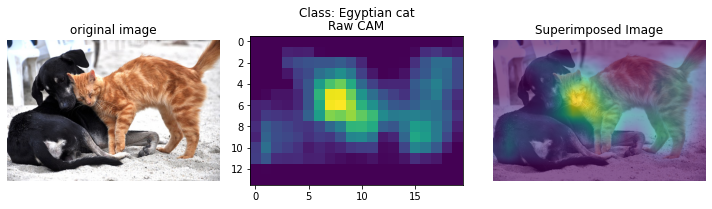

In [14]:
# Grad-CAM for egyptian cat
wrapped_model_GradCAM = GradCAM(model, target_layer,285)
gcam_cat, idx_pred = wrapped_model_GradCAM(tensor)
visualize(image,tensor,gcam_cat,idx_pred)

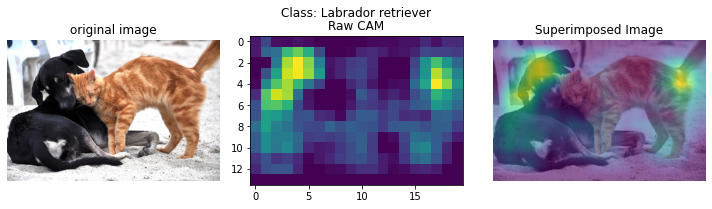

In [15]:
# Grad-CAM for Labrador Retriever
wrapped_model_GradCAM = GradCAM(model, target_layer,208)
gcam_dog, idx_pred = wrapped_model_GradCAM(tensor)
visualize(image,tensor,gcam_dog,idx_pred)

As it can be observed Grad-CAM highlights parts related to the desired classes. However one of its limitations is that can lose information in the backpropagation process (vanishing gradient) due to Sigmoid and ReLU activations.

On CVPR 2020, a combination of perturbation methods and Class Activation Mapping was presented: Score-CAM.

## Score-CAM 


Score-CAM is another method based on Class Activation Mapping (CAM). This method unlike others that follow CAM approach does not use gradients and gets   the weight of each activation map through its forward passing when applied as a mask to the input, then the final score is obtained by a linear combination of weights and activation maps[1]. The  published paper is available [here](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w1/Wang_Score-CAM_Score-Weighted_Visual_Explanations_for_Convolutional_Neural_Networks_CVPRW_2020_paper.pdf)  and official code is on [Github](https://github.com/haofanwang/Score-CAM).




![picture](https://raw.githubusercontent.com/RosePY/deepexplain/ScoreCAM/ScoreCAM/images/score-cam.png)

*Figure 1: Outline of Score-CAM. Activation maps are first extracted in Phase 1. Each activation then works as a mask on
original image, and obtain its forward-passing score on the target class. Phase 2 repeats for N times where N is the number of activation
maps. Finally, the result can be generated by linear combination of score-based weights and activation maps. Phase 1 and Phase 2 shares a
same CNN module as feature extractor. Figure reproduced from Wang et al.[1].*


### Algorithm
1.   Feed the input image through the CNN.
2.   Extract  activation maps at the desired layer (usually the last convolutional layer)
2.   Upsample the activation maps to the original input size in the network
3.   Normalize maps values in the range of 0-1
4.   Apply the activation map as a mask to the input by multiplying it with the normalized activation map
5.   Feed masked inputs into CNN model and get the softmax values
6.   Define the softmax value as the score of target class
7.   Get final class discriminative localization map as linear weighted combination of all activation maps and softmax values
7.   Scale values to the interval between 0 and 1 for visualization purposes
8.   Upscale the image and overlay it over the original image



### Example

In [16]:
# Code adapted from https://github.com/yiskw713/ScoreCAM
class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer,idx, n_batch=32):
        super().__init__(model, target_layer,idx)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            # 1. object classification
            score = self.model(x)

            prob = F.softmax(score, dim=1)

            if self.idx is None:
                prob, idx = torch.max(prob, dim=1)
                self.idx = idx.item()
                #prob = prob.item()
                #print("predicted class ids {} - {} \t probability {}".format(idx,idx2label[int(idx)], prob))
        
            # 2. Getting activation maps
            self.activations = self.values.activations.to('cpu').clone()
            self.activations = F.relu(self.activations)
            # 3. Upsampling
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # 4. Normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

           # 5. generate masked images and 5. calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                # Get probabilities for each class
                torch_scores = torch.cat((1-score,score),1).to(device)
                probs.append(F.softmax(score, dim=1)[:, self.idx].to('cpu').data)

            # 7. Extracting weight as the score 
            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # 8. Linear weighted combination
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, self.idx

    def __call__(self, x):
        return self.forward(x)

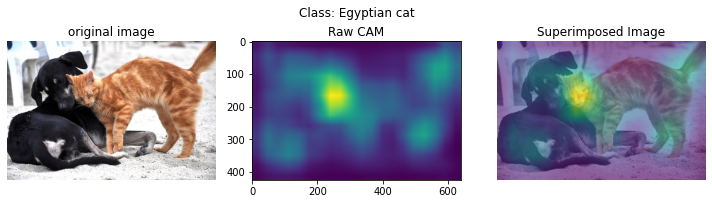

In [17]:
# Score-CAM for egyptian cat. Exceution in Colab-GPU can take around three minutes
wrapped_model_ScoreCAM = ScoreCAM(model, target_layer,285)
scam_cat, idx_pred = wrapped_model_ScoreCAM(tensor)
visualize(image,tensor,scam_cat,idx_pred)

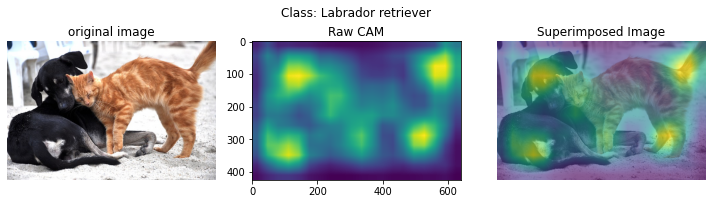

In [18]:
# Score-CAM for Labrador Retriever.  Exceution in Colab-GPU can take around three minutes
wrapped_model_ScoreCAM = ScoreCAM(model, target_layer,208)
scam_dog, idx_pred = wrapped_model_ScoreCAM(tensor)
visualize(image,tensor,scam_dog,idx_pred)

Similar to the other CAM-based mehods, Score-CAM shows parts related to the desired class. However one of the biggest limitation of CAM-based method is the final size of the class discriminative localization map (saliency map), which depending on the network architecture can be really small and of very low resolution. For example, in the shown examples this map is of 20 * 20 pixels, and is upsampled to the image input size.

It is important to note that these methods are based on only one image (Local Methods), they explain the prediction for an input. Thus, to draw a conclusion for each class with these methods, the human will have to do it in a one-by-one
process. 



## Analysis: Drawbacks of saliency-based methods

*  Some saliency-based methods are not robust, since they are vulnerable to 
adversarial attacks[4].

 Kindermans and Hooker[5] explored how some saliency methods behaved when the input data was shifted, e.g. change in the input encoding from [0; 1] to [−1; 0], addition of constant squares or a hand drawn cat image in the background. Their results showed that explanations generated by methods such as Deconvolution, Integrated Gradients are different than the ones produced before these simple transformations, which means that explanations can be manipulated and these methods are not reliable.



* Saliency methods can obtain deceitful explanations. 

    For example, in Figure 6, in the first row it can be seen in the firt
row the results for some Backpropagation-based Methods and Perturbation-based Methods for the label “chocolate-sauce”, and how different the heatmaps are.  To prove what method was accurate, the pot and spoon regions were occluded with red boxes and the resulted predictions were compared, demonstrating that the DNN was focused on the spoon. This can be because of some bias in the dataset (most of chocolate sauce images have a spoon)[3].


![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/falsifiabl.png?raw=true)
*Figure 6: Different explanations for the label “Chocolate sauce” (first row). In the second row, parts of the image are occluded to see changes on prediction accuracy the label ‘chocolate sauce’, when occluding the chocolate pot, the accuracy for this label drops from 0.61 to be 0.351. However, if just the the spoon is occluded, the accuracy  drops to 0.015, even though the image still contains the chocolate pot. Figure reproduced from Fong et al.[3].*


*   Visual explanations methods are still difficult to evaluate:

    Sanity Checks[2], evaluates qualitative and quantitatively explanations based on the fact that if the prediction changes, the explanation would also change. For this, they performed two types of tests: the model parameter randomization test, and the data randomization test. Saliency methods need to be sensitive to model parameters. 

    Figure 4 shows the explanation for an age bone predictor trained on Inception-v4 and after randomizing all the weights in the model. 

    Figure 5 shows the performance of saliency methods after applying a cascading randomization on Inception V3 trained with ImageNet. Notice that even though the weights on the network change (that is, the prediction changed), the saliency map of some methods remains the same.

    However, there are also Sanity Checks for Saliency metrics [9] that proved that current metrics are not reliable to evaluater whether a method is capturing the true relevance of the pixels to the classifier output.

![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/sanity-smooth.png?raw=true)

*Figure 4: Explanations B (trained Inception v4) and C (Inception v4 with Random weights) showing no difference. Figure reproduced from Adebayo et al.[2].*

![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/saliency.png?raw=true)

*Figure 5: Saliency results for diverse methods after Cascading Randomization on Inception
V3. Some methods do not accomplish sanity check question: When prediction changes, do explanations
change? Figure reproduced from Adebayo et al.[2].*



## References
[1] H. Wang, Z. Wang, M. Du, F. Yang, Z. Zhang, S. Ding, P. Mardziel e X. Hu. Score-cam:
Score-weighted visual explanations for convolutional neural networks. In Proceedings of
the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops, pages
24–25, 2020.

[2] J. Adebayo, J. Gilmer, M. Muelly, I. Goodfellow, M. Hardt e B. Kim. Sanity checks for saliency maps. Advances in Neural Information Processing Systems, 2018-Decem(NIPS):
9505–9515, 2018. ISSN 10495258.

[3] R. C. Fong e A. Vedaldi. Interpretable explanations of black boxes by meaningful perturbation. In Proceedings of the IEEE International Conference on Computer Vision, pages
3429–3437, 2017. 

[4] A. Ghorbani, A. Abid e J. Zou. Interpretation of neural networks is fragile. Proceedings
of the AAAI Conference on Artificial Intelligence, 33(01):3681–3688, Jul. 2019. doi: 10.
1609/aaai.v33i01.33013681. URL https://ojs.aaai.org/index.php/AAAI/article/view/4252. 

[5] P.-J. Kindermans, S. Hooker, J. Adebayo, M. Alber, K. T. Schutt, S. D ¨ ahne, D. Erhan e ¨
B. Kim. The (Un)reliability of Saliency Methods, pages 267–280. Springer International 
Publishing, Cham, 2019. ISBN 978-3-030-28954-6. doi: 10.1007/978-3-030-28954-6 URL https://doi.org/10.1007/978-3-030-28954-6_14

[6] B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

[7] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization," 2017 IEEE International Conference on Computer Vision (ICCV), 2017, pp. 618-626, doi: 10.1109/ICCV.2017.74.

[8] Molnar, C. (2020). Interpretable machine learning. https://christophm.github.io/interpretable-ml-book/

[9] Tomsett, R., Harborne, D., Chakraborty, S., Gurram, P., & Preece, A. (2020, April). Sanity checks for saliency metrics. In Proceedings of the AAAI conference on artificial intelligence (Vol. 34, No. 04, pp. 6021-6029).